In [7]:
# general modules
import os
import numpy as np
import pandas as pd
import scipy.stats as st

# visualization modules
from plotnine import (
    ggplot, geom_density, geom_errorbar, geom_line, geom_point, xlab, ylab,
    ggtitle, theme, facet_wrap, geom_boxplot, geom_violin, geom_bar,  aes
)

import json
from sklearn.model_selection import train_test_split
from shutil import which

# inner modules
from houses_pipeline.constants import CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS

### Load the data

In [8]:
houses_df = pd.read_csv("../data/raw/train.csv")
houses_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [9]:
houses_df.shape

(1460, 81)

### Explore missing values

In [10]:
null_props = houses_df.isnull().mean()
null_props = null_props[null_props > 0]
null_props.sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

Some of the nans are just None.

### Is there any relationship of missing values with the response

The above plot doesn't give us a lot of information on the certainty of the Sale Price since the sample size might be too small.

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_97749/61792541.py:7: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_97749/61792541.py:10: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/plotnine/facets/facet.py:434: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust

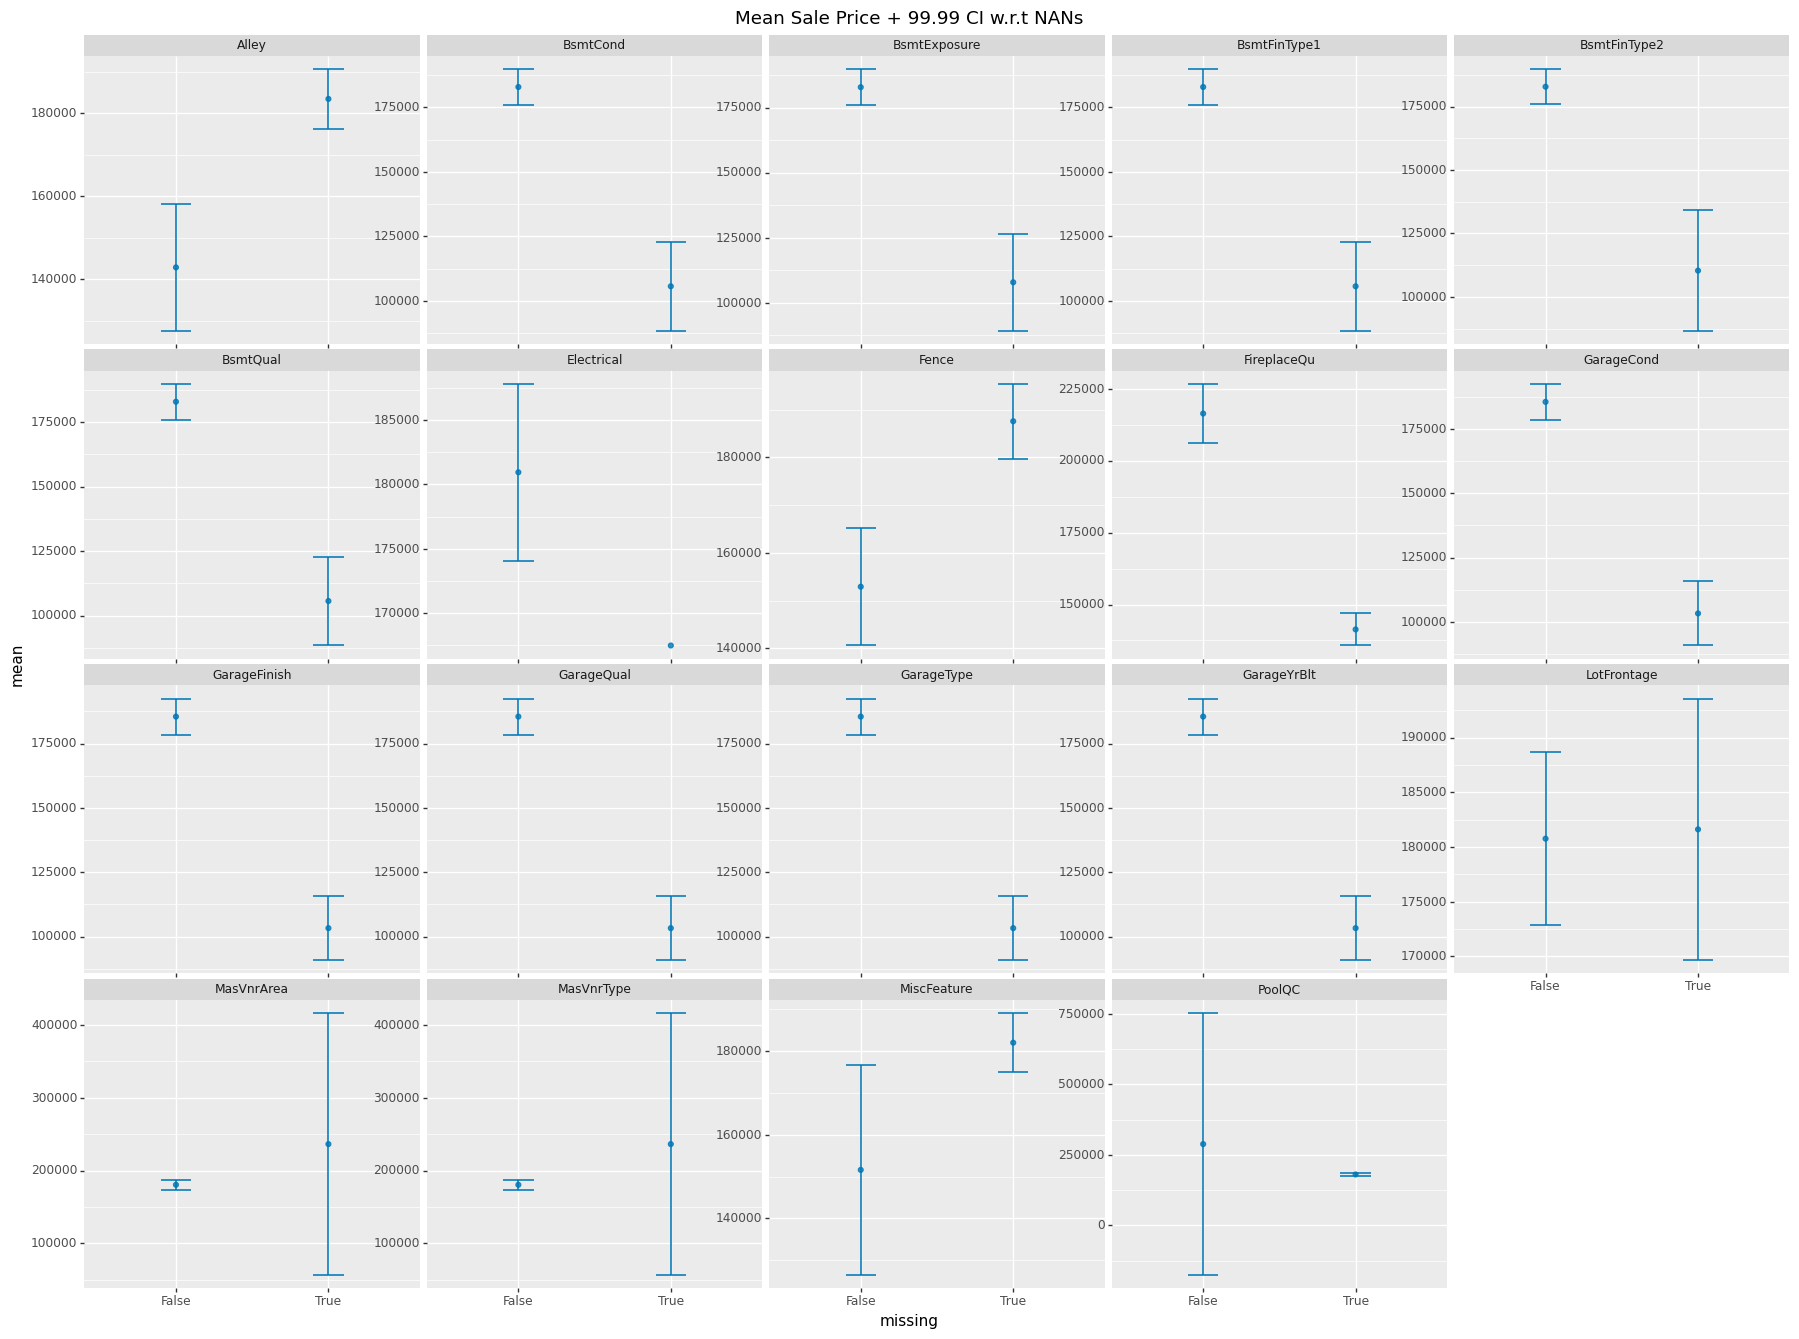

<ggplot: (381235493)>

In [15]:
(houses_df[np.append(null_props.index.values, 'SalePrice')]
 .melt(id_vars=['SalePrice'])
 .assign(missing=lambda df: df['value'].isnull())
 .groupby(['variable', 'missing'])
 .agg({"SalePrice": [
    np.mean,
    lambda x: st.t.interval(
      alpha=0.999, df=len(x) - 1, loc=x.mean(), scale=st.sem(x)
   )[0],
    lambda x: st.t.interval(
   
      alpha=0.999, df=len(x) - 1, loc=x.mean(), scale=st.sem(x))[1]
 ]})
 .set_axis(['mean', 'lower', 'upper'], axis=1, inplace=False)
 .reset_index()
 .pipe(ggplot) +
    aes(x='missing', y='mean', color='missing') +
        geom_point(color="#0077b6", alpha=0.8) +
        aes(x='missing', ymin='lower', ymax='upper', color='missing') +
        geom_errorbar(width=.2, size=0.8, color="#0077b6", alpha=0.8) +
        facet_wrap('variable', scales='free') +
        ggtitle("Mean Sale Price + 99.99 CI w.r.t NANs") +
        theme(figure_size=(22, 16))
)


- Since the number of missing values in MasVnrArea and MasVnrType are too few, as well as Electrical, we can remove those observations.
- For the column MiscFeature, PoolQC we are too uncertain so we can probably remove the columns completely.
- LotFrontage looks like it can be imputed with a standard imputation mechanism. This should be done in the resampling
- Rest of the columns can be imputed with a new value (Missing if categorical). GarageYrBlt can be dropped.
- Rare categories can be imputed with Rare
<!-- Идея: когато липсват стойности, отклика си има някакво средно, ако направим обърнат линеен модел -->

In [22]:
(houses_df['GarageYrBlt'] == houses_df['YearBuilt']).mean()

0.7458904109589041

Nearly 75% of the garage year is the same as the house year. 5% are missing, so replacing those 5% with the house year wouldn't not loose too much information/

### Replace NaNs in categorical columns with Missing

In [19]:
# replace nans with missing category
houses_processed_df = houses_df.copy()
categorical_columns = houses_processed_df.columns & CATEGORICAL_COLUMNS
houses_processed_df[categorical_columns] = houses_processed_df[
    categorical_columns
].fillna('Missing')

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_97749/2312104309.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.


/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 259 rows containing missing values.


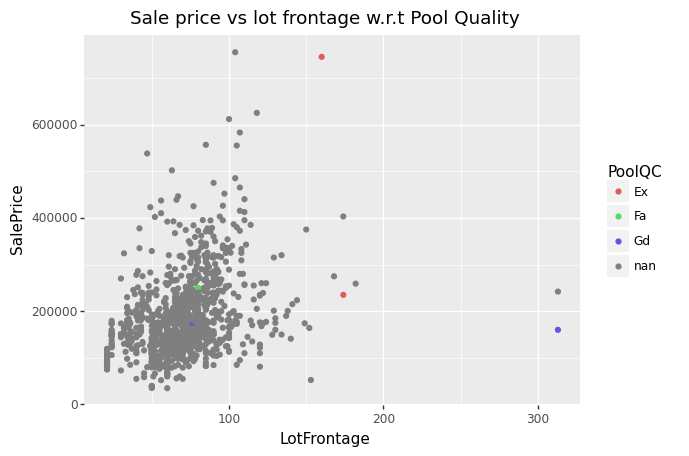

<ggplot: (381844553)>

In [24]:
(ggplot(houses_df) +
    aes(x='LotFrontage', y='SalePrice', color='PoolQC') +
    geom_point() +
    ggtitle("Sale price vs lot frontage w.r.t Pool Quality")
)

Pool quality seems to be useless.


### Checking for redundant variables
- most of the values of a column are the same
- check for categories which are too much of the same value
- the column is the same as another column
- duplicate rows
- in the initial data analysisto be curious, after making a preliminary analysis, gather questions. Maybe after you can proceed to the exploratory data analysis.
    - After presenting the EDA, you can discuss possible business questions, variables that can be used in modeling.
- Try to have fixed dataset, not being mutable by DE team



In [31]:
ext_first = houses_processed_df['Exterior1st']
ext_second = houses_processed_df['Exterior2nd']
print((ext_first == ext_second).mean())

# mostly the same as 1st floor so drop the 2nd floor exterior column so drop it
houses_processed_df = houses_processed_df.drop(['Exterior2nd'], axis=1)

0.853893866299104


We can drop GarageYrBlt, Exterior2nd, SaleYr, PoolQC, MiscFeature